In [ ]:
from keras.models import load_model
model = load_model('formal_informal_dress_cnn_withaugmentation.h5')
model.summary()

In [ ]:
img_path = "C:/Users/rani/Desktop/Documents/Rani_Rathore_2020PUSCEBAIX08719.jpg"

In [ ]:
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path ,target_size =(150,150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor/=255.

In [ ]:
img_tensor.shape

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show()

In [ ]:
from keras import models

model.layers

In [ ]:
layer_outputs = [layer.output for layer in model.layers[:8]] 

In [ ]:
 activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [ ]:
activations = activation_model.predict(img_tensor)

In [ ]:
 first_layer_activation = activations[0]

In [ ]:
 print(first_layer_activation.shape)

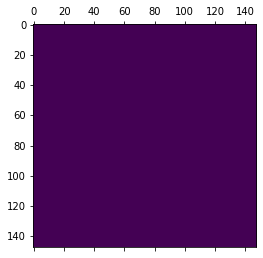

In [101]:
import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

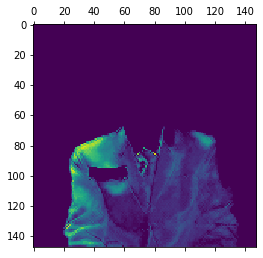

In [102]:
 plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')

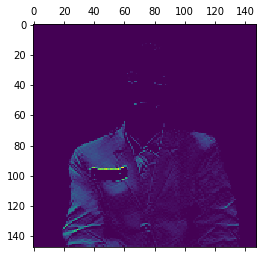

In [103]:
 plt.matshow(first_layer_activation[0, :, :, 17], cmap='viridis')

#### Visualizing every channel in every intermediate activation

In [104]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

In [105]:
layer_names

['vgg16', 'flatten', 'dense', 'dense_1']

C:\Users\rani\AppData\Local\Temp\ipykernel_9696\3236913707.py:11: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()
C:\Users\rani\AppData\Local\Temp\ipykernel_9696\3236913707.py:14: RuntimeWarning: invalid value encountered in cast
  channel_image = np.clip(channel_image, 0, 255).astype('uint8')


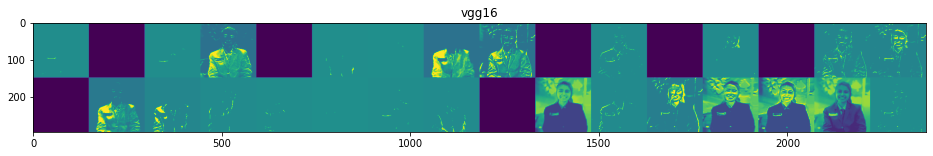

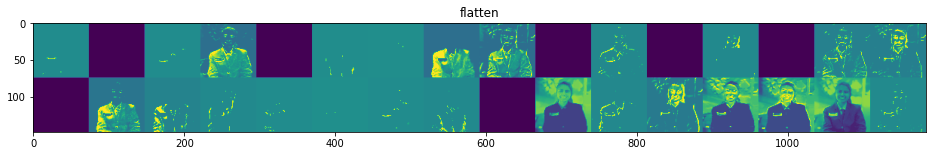

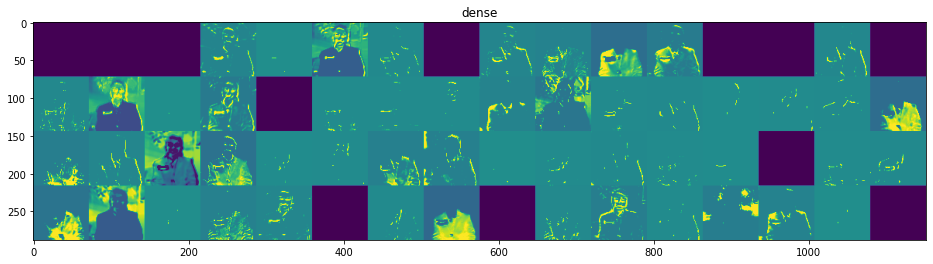

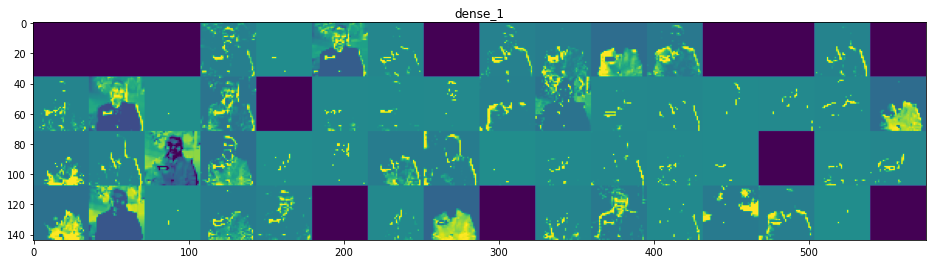

In [106]:
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :,col * images_per_row + row]
            channel_image-= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
    scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

#  Visualizing convnet filters

In [107]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',include_top=False)

layer_name = 'block3_conv1'
filter_index = 0
layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])
print(loss)

KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='tf.math.reduce_mean_5/Mean:0', description="created by layer 'tf.math.reduce_mean_5'")


In [108]:
import tensorflow as tf
grads = tf.GradientTape(loss, model.input)

In [109]:
grads

In [110]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

ValueError: Attempt to convert a value (<tensorflow.python.eager.backprop.GradientTape object at 0x00000157D1410520>) with an unsupported type (<class 'tensorflow.python.eager.backprop.GradientTape'>) to a Tensor.

In [111]:
iterate = K.function([model.input], [loss, grads])
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

ValueError: Output tensors of a Functional model must be the output of a TensorFlow `Layer` (thus holding past layer metadata). Found: <tensorflow.python.eager.backprop.GradientTape object at 0x00000157D1410520>

In [112]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.
step = 1.
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

NameError: name 'iterate' is not defined

In [113]:
def deprocess_image(x):
    x-= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [114]:
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    img = input_img_data[0]
    return deprocess_image(img)

In [115]:
plt.imshow(generate_pattern('block3_conv1', 0))

RuntimeError: tf.gradients is not supported when eager execution is enabled. Use tf.GradientTape instead.

# class activation map (CAM) visualization

In [116]:
from keras.applications.vgg16 import VGG16

In [ ]:
model = VGG16(weights='imagenet')

    24576/553467096 [..............................] - ETA: 87:40:57

In [ ]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [ ]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

In [ ]:
african_e66lephant_output = model.output[:, 386]
last_conv_layer = model.get_layer('block5_conv3')

In [ ]:
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input],[pooled_grads, last_conv_layer.output[0]])

In [ ]:
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)

In [ ]:
import cv2
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('/Users/fchollet/Downloads/elephant_cam.jpg', superimposed_img)